# SINDy From Scratch

The goal of this file is to implement the algorithm from scratch, applied to the Lorenz system to reproduce the result of the paper. The optimization algorithm is sequential thresholding with threshold parameter $\alpha=0.025$.

The Lorenz system used in paper has parameters $\sigma=10, \beta=\frac83,\rho=28$ and initial condition $(x(0),\ y(0),\ z(0))^T=(-8,\ 8,\ 27)^T$. So the system is 

$$
\begin{cases}
    x'=10(y-x)\\
    y'=x(28-z)-y\\
    z'=xy-\frac83 z
\end{cases}
$$

The training data is generated in the time interval $t\in[0,100]$ with time-step $\Delta t = 0.001$.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "notebook", "grid"])

# Generate Data

In [2]:
# generate data
def lorenz(t, x, sigma=10, beta=8/3, rho=28):
    """
    Lorenz system data

    Args:
        x (array): Data
        sigma (float, optional): Parameter. Defaults to 10.
        beta (float, optional): Parameter. Defaults to 8/3.
        rho (float, optional): Parameter. Defaults to 28.

    Returns:
        array: Lorenz system data
    """
    return [sigma * (x[1] - x[0]), x[0] * (rho - x[2]) - x[1], x[0] * x[1] - beta * x[2]]

x0 = [-8, 8, 27]
delta_t= 0.001
t = np.arange(0, 100, delta_t)
x = solve_ivp(lorenz, t_span = (t[0], t[-1]), y0 = x0, t_eval=t, rtol = 1e-12, method = "LSODA", atol = 1e-12).y.T

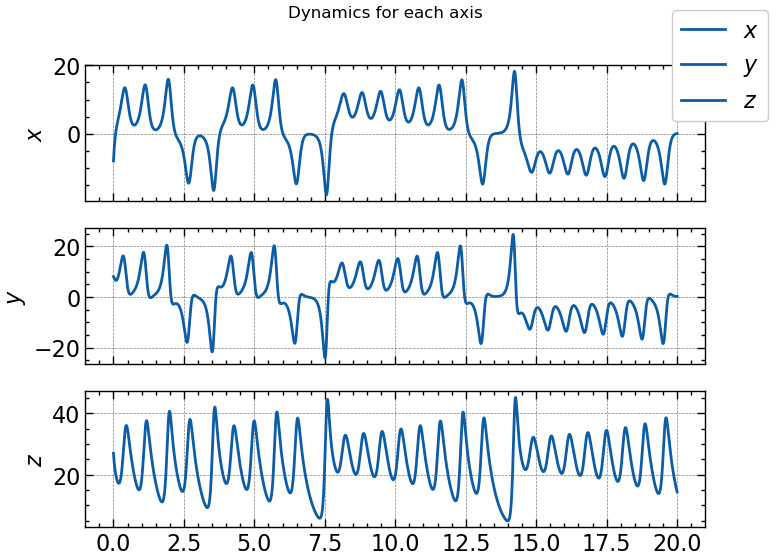

In [3]:
fig, axs = plt.subplots(3, 1, sharex=True)
ax = axs[0]
ax.plot(t[:int(20/delta_t)], x[:int(20/delta_t) , 0], label = "$x$") # show up to time t=20
ax.set_ylabel("$x$")
ax = axs[1]
ax.plot(t[:int(20/delta_t)], x[:int(20/delta_t) , 1], label = "$y$")
ax.set_ylabel("$y$")
ax = axs[2]
ax.plot(t[:int(20/delta_t)], x[:int(20/delta_t) , 2], label = "$z$")
ax.set_ylabel("$z$")
fig.legend()
fig.suptitle("Dynamics for each axis")
plt.tight_layout
plt.show()

In [4]:
# derivative 
x_dot = np.array([lorenz(0, x[t]) for t in range(t.size)]) # X'

array([[ 160.        ,  -16.        , -136.        ],
       [ 158.24431967,  -16.88387161, -134.2377595 ],
       [ 156.49759002,  -17.71263717, -132.49280333],
       [ 154.76026179,  -18.48799909, -130.76573334],
       [ 153.03276447,  -19.21162758, -129.05709225]])

# Functions for the Algorithm

In [5]:
def SparseRegression(library, derivative, n, alpha = 0.025, max_iter = 20):
    """
    Computes sparse optimization via least-squares using sequential thresholding

    Args:
        library (array_like): A matrix representing the library used to model the dynamics
        derivative (array_like): A matrix representing the time derivatives of the state variable x
        n (int): The dimensionality of the state variable x
        alpha (float, optional): Threshold parameter to cut-off coefficients to 0. Defaults to 0.025.
        max_iter (int, optional): Number of sequential least-squares to compute. Defaults to 20.

    Returns:
        coeff (ndarray): Coefficients xi
    """
    
    if alpha < 0 or n < 0 or max_iter < 0:
        raise ValueError("Negative input not accepted")
    
    coeff = np.linalg.lstsq(library, derivative, rcond=None)[0] # least-square, no sparse
    
    for i in range(max_iter): # remove small coefficients
        small_coeff_bool = np.abs(coeff) < alpha # 0 if >=alpha, 1 if < alpha
        coeff[small_coeff_bool] = 0
        for k in range(n): # iterate on each state dimension
            big_coeff_bool = small_coeff_bool[:, k] == 0 # column of current dimension that has non-small coefficients
            coeff[big_coeff_bool, k] = np.linalg.lstsq(library[:, big_coeff_bool], derivative[:, k], rcond=None)[0] # update non-small coeff on new least-squares 
    
    return coeff

In [6]:
def generatePolyLibrary(x_in, n, poly_order=3):
    """
    Generates the library matrix from data, with polynomial (very inefficiently, but it works) of order 3.

    Args:
        x_in (array_like): Input data
        n (int): Number of variables in the input data x
        poly_order (int): Maximum polynomial order for feature generation. Defaults to 3.
        
    Returns:
        theta: Expanded data according to the library matrix
    """
    
    m = x_in.shape[0]
    p = 1 + n + (n * (n + 1) // 2) + (n * (n + 1) * (n + 2) // (2 * 3)) + 11 # found in the code of the library (3rd order poly)
    theta = np.zeros((m,p)) # library initialized as empty
    
    # order 0 (constants)
    column_p = 0
    theta[:, column_p] = np.ones(m)
    
    # order 1 (linear)
    column_p = 1
    for i in range(n):
        theta[:, column_p] = x_in[:, i]
        column_p += 1
        
    if poly_order >= 2: # order 2 (quadratic)
        for i in range(n):
            for j in range(i, n):
                theta[:, column_p] = x_in[:, i] * x_in[:, j] # i and j columns of input
                column_p += 1
    if poly_order >= 3: # order 3 (cubic)
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    theta[:, column_p] = x_in[:, i] * x_in[:, j] * x_in[:, k]
                    column_p += 1
    
    return theta

# Algorithm

In [7]:
poly_lib = generatePolyLibrary(x_in=x, n=x.shape[1], poly_order=3) # theta library
coefficients = SparseRegression(library=poly_lib, derivative=x_dot, n=x.shape[1], alpha=0.025, max_iter=20)

In [8]:
coefficients

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

The columns correspond to $x', y'$ and $z'$ respectively. The rows are the candidate functions, so $1,x,y,z,x^2,xy,\dots, z^3$. The model is identified correctly.

# Further Analysis

In [9]:
def SparseRegression_lens(library, derivative, n, alpha=0.1, max_iter=20):
    """
    Just like SparseRegression, but stops as soon as the 
    It's called lens, because it's a zoomed in version of the original function, so we can interpret the results at each iteration
    """
     
    if alpha < 0 or n < 0 or max_iter < 0:
        raise ValueError("Negative input not accepted")
    
    coeff = np.linalg.lstsq(library, derivative, rcond=None)[0]
    
    print("Iteration 0 Coefficients:")
    print(coeff)
    
    for i in range(max_iter):  # remove small coefficients
        small_coeff_bool = np.abs(coeff) < alpha  # 0 if >= alpha, 1 if < alpha
        coeff[small_coeff_bool] = 0
        
        if np.allclose(coeff, coefficients): # allclose (and not ==) to avoid floating point issues
            print(f"Model identified correctly at iteration {i+1}, with coefficients:")
            return coeff
        
        for k in range(n):  # iterate on each state dimension
            big_coeff_bool = small_coeff_bool[:, k] == 0  # column of current dimension that has non-small coefficients
            coeff[big_coeff_bool, k] = np.linalg.lstsq(library[:, big_coeff_bool], derivative[:, k], rcond=None)[0]  # update non-small coeff on new least-squares


In [10]:
coefficients_lens = SparseRegression_lens(library=poly_lib, derivative=x_dot, n=x.shape[1], alpha=0.05, max_iter=20)
coefficients_lens

Iteration 0 Coefficients:
[[-8.68986361e-11  2.24406571e-10  4.29464238e-12]
 [-1.00000000e+01  2.80000000e+01  2.66663620e-13]
 [ 1.00000000e+01 -1.00000000e+00 -1.26662520e-13]
 [ 2.38443849e-13  7.22316283e-13 -2.66666667e+00]
 [-3.04158785e-13  6.37985173e-13  7.30646850e-14]
 [ 8.53733110e-14 -2.98275645e-13  1.00000000e+00]
 [ 3.32628190e-14 -1.00000000e+00 -5.99156399e-16]
 [ 3.27378141e-14 -5.01712204e-14 -4.55006693e-15]
 [-1.80919953e-14  4.41728891e-14 -4.14742824e-16]
 [ 4.95795659e-14 -1.57056367e-13 -1.12024188e-15]
 [ 4.50125652e-16 -3.58775735e-15  2.06744143e-15]
 [-2.22965021e-15  4.40905677e-15 -2.36654362e-15]
 [ 6.23864503e-15 -1.21006915e-14 -6.00168745e-16]
 [ 4.76444186e-17 -7.73025977e-16  8.40279890e-16]
 [-3.14731216e-15  8.16700058e-15  1.55813320e-16]
 [-2.89118417e-16  1.48178988e-15 -3.08227457e-16]
 [ 8.70670456e-17 -1.90178707e-16 -2.71779383e-16]
 [-6.42842407e-16 -4.28875139e-16  1.68617009e-17]
 [ 3.45350660e-16 -8.04620956e-16  1.46648071e-16]
 [-1.

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

So the right model is identified with just one iteration of the sequential thresholded least-squares algorithm!